# **IRB Retail Mortgage**
## **Data Preparation and EDA**

## **Data Ingestion**
Importing the retail mortgage dataset [Check Data Description](../README.md)

In [1]:
# importing the required modules
import sys
sys.path.append("..")

from src.config import *
from src.utility_functions import *

In [2]:
# loading the raw mortgage dataset
mortgage_raw = save_as_pickle_if_not_exists_and_load(pickle_file_path = f"{main_dir}/data/raw/accepted_2007_to_2018Q4.pkl")
mortgage_raw.head(5)

Pickle file already exists at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//data/raw/accepted_2007_to_2018Q4.pkl
(2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0000,3600.0000,3600.0000,36 months,13.9900,123.0300,C,C4,leadman,10+ years,MORTGAGE,55000.0000,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.9100,0.0000,Aug-2003,675.0000,679.0000,1.0000,30.0000,NaN,7.0000,0.0000,2765.0000,29.7000,13.0000,w,0.0000,0.0000,4421.7239,4421.7200,3600.0000,821.7200,0.0000,0.0000,0.0000,Jan-2019,122.6700,NaN,Mar-2019,564.0000,560.0000,0.0000,30.0000,1.0000,Individual,NaN,NaN,NaN,0.0000,722.0000,144904.0000,2.0000,2.0000,0.0000,1.0000,21.0000,4981.0000,36.0000,3.0000,3.0000,722.0000,34.0000,9300.0000,3.0000,1.0000,4.0000,4.0000,20701.0000,1506.0000,37.2000,0.0000,0.0000,148.0000,128.0000,3.0000,3.0000,1.0000,4.0000,69.0000,4.0000,69.0000,2.0000,2.0000,4.0000,2.0000,5.0000,3.0000,4.0000,9.0000,4.0000,7.0000,0.0000,0.0000,0.0000,3.0000,76.9000,0.0000,0.0000,0.0000,178050.0000,7746.0000,2400.0000,13734.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0000,24700.0000,24700.0000,36 months,11.9900,820.2800,C,C1,Engineer,10+ years,MORTGAGE,65000.0000,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.0600,1.0000,Dec-1999,715.0000,719.0000,4.0000,6.0000,NaN,22.0000,0.0000,21470.0000,19.2000,38.0000,w,0.0000,0.0000,25679.6600,25679.6600,24700.0000,979.6600,0.0000,0.0000,0.0000,Jun-2016,926.3500,NaN,Mar-2019,699.0000,695.0000,0.0000,NaN,

In [3]:
# columns of the datasets 
# print(sorted(list(mortgage_raw.columns)))

# to search any column in the dataset we can use the following syntax 
[i for i in mortgage_raw.columns if 'id' in i.lower() or 'loan' in i.lower() or 'status' in i.lower() or 'default' in i.lower()]

# loan status is the variable using which we can define the default flag
model_cols = id_cols + loan_contract_cols + borrower_profile_cols + ["loan_status"] 

# extracting the required columns of interest for the model building
mortgage_raw = mortgage_raw[model_cols].copy()
mortgage_raw.shape

(2260701, 25)

## **Portfolio Definition & Basic Filters**

In [4]:
# id is loan_id  and issue_d is issue date (origination date)
# checking the duplicates in loan id
print(mortgage_raw.id.value_counts(dropna=False).unique())

# checking the value counts of the issue dates 
mortgage_raw.issue_d.value_counts(dropna=False).sort_index()

[1]


issue_d
Apr-2008      259
Apr-2009      333
Apr-2010      912
Apr-2011     1563
Apr-2012     3230
            ...  
Sep-2015    28641
Sep-2016    28144
Sep-2017    39713
Sep-2018    39026
NaN            33
Name: count, Length: 140, dtype: int64

In [5]:
# the data is unique on loan_id which is "id" in the dataset 
# converting the issue date to datetime format as month end dates and removing cases where issue date is missing
mortgage_raw = mortgage_raw[~mortgage_raw.issue_d.isna()].copy()
mortgage_raw['t0'] = pd.to_datetime(mortgage_raw['issue_d'], format='%b-%Y') + pd.offsets.MonthEnd(0)
mortgage_raw.t0.value_counts(dropna=False).sort_index()

t0
2007-06-30       24
2007-07-31       63
2007-08-31       74
2007-09-30       53
2007-10-31      105
              ...  
2018-08-31    46079
2018-09-30    39026
2018-10-31    46305
2018-11-30    41973
2018-12-31    40134
Name: count, Length: 139, dtype: int64

- The **loan_status** variable represents the final observed outcome of the loan and is used only to define whether the loan ever defaulted. The dataset does not provide sufficient information to determine the exact timing of default within the loan lifecycle.

In [6]:
# loan status 
display(mortgage_raw.loan_status.value_counts(dropna=False).sort_index())

loan_status
Charged Off                                             268559
Current                                                 878317
Default                                                     40
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1076751
In Grace Period                                           8436
Late (16-30 days)                                         4349
Late (31-120 days)                                       21467
Name: count, dtype: int64

In [7]:
# creating the default flag
# if the loan is charged off or defaulted can beconsidered as default cases remaining categories fall under non-defaulted cases

default_categories = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']
mortgage_raw['default_flag'] = mortgage_raw['loan_status'].isin(default_categories).astype(int)
pd.crosstab(mortgage_raw["loan_status"], mortgage_raw["default_flag"], normalize="index")

default_flag,0,1
loan_status,,
Charged Off,0.0000,1.0000
Current,1.0000,0.0000
Default,0.0000,1.0000
Does not meet the credit policy. Status:Charged Off,0.0000,1.0000
Does not meet the credit policy. Status:Fully Paid,1.0000,0.0000
Fully Paid,1.0000,0.0000
In Grace Period,1.0000,0.0000
Late (16-30 days),1.0000,0.0000
Late (31-120 days),1.0000,0.0000


## **Exploratory Data Analysis (EDA)**

Basic checks for modelling datasets
1. Loan id should be unique 
2. Unique values in a feature should be as expected 
3. The values of a feature should be stored as correct data types

In [8]:
model_df = mortgage_raw.copy()

# basic checks for modeling dataset
print(model_df.shape[0] == model_df["id"].nunique())
print(model_df.nunique().sort_values())
print(model_df.dtypes)

True
default_flag                 2
term                         2
verification_status          3
home_ownership               6
grade                        7
loan_status                  9
emp_length                  11
purpose                     14
inq_last_6mths              28
sub_grade                   35
delinq_2yrs                 37
pub_rec                     43
open_acc                    91
t0                         139
issue_d                    139
total_acc                  152
int_rate                   673
revol_util                1430
funded_amnt               1572
loan_amnt                 1572
funded_amnt_inv          10057
dti                      10845
annual_inc               89368
installment              93301
revol_bal               102251
emp_title               512694
id                     2260668
dtype: int64
id                             object
issue_d                        object
term                           object
loan_amnt                     f

### **Target and Portfolio Overview**

- In this section, we perform high-level exploratory checks to:
    - Understand the overall default rate
    - Verify that default behavior is sensible across key dimensions
    - Ensure the target variable behaves as expected

- No transformations or modeling decisions are made here.
- This step is purely diagnostic, similar to PROC FREQ and PROC MEANS in SAS.

In [9]:
# portfolio size
n_loans = model_df.shape[0]

# checking portfolio-level PD across full horizon
overall_pd = model_df["default_flag"].mean()

# default rate by loan term (36 vs 60 months)
pd_by_term = model_df.groupby("term")["default_flag"].mean()

# default rate by by credit grades 
pd_by_grade = model_df.groupby("grade")["default_flag"].mean().sort_index()

# default rate by loan purpose 
pd_by_purpose = model_df.groupby("purpose")["default_flag"].mean().sort_values(ascending=False)

# default rate by income verification status
pd_by_verification = model_df.groupby("verification_status")["default_flag"].mean()

# checking default rate across loan amount deciles
loan_amt_bins = pd.qcut(model_df["loan_amnt"], 10)
pd_by_loan_amt = model_df.groupby(loan_amt_bins)["default_flag"].mean()


print(f"Number of loans in portfolio: {n_loans:,}")
print(f"Overall portfolio default rate: {overall_pd:.2%}")
print("\nDefault rate by loan term:")
for term, pd_rate in pd_by_term.items():
    print(f"  Term {term}: {pd_rate:.2%}")

print("\nDefault rate by credit grade:")
for grade, pd_rate in pd_by_grade.items():
    print(f"  Grade {grade}: {pd_rate:.2%}")

print("\nDefault rate by loan purpose:")
for purpose, pd_rate in pd_by_purpose.items():
    print(f"  {purpose}: {pd_rate:.2%}")

print("\nDefault rate by verification status:")
for status, pd_rate in pd_by_verification.items():
    print(f"  {status}: {pd_rate:.2%}")

print("\nDefault rate by loan amount deciles:")
for bin_range, pd_rate in pd_by_loan_amt.items():
    print(f"  {bin_range}: {pd_rate:.2%}")

Number of loans in portfolio: 2,260,668
Overall portfolio default rate: 11.92%

Default rate by loan term:
  Term  36 months: 10.18%
  Term  60 months: 16.20%

Default rate by credit grade:
  Grade A: 3.28%
  Grade B: 7.94%
  Grade C: 13.20%
  Grade D: 18.88%
  Grade E: 26.69%
  Grade F: 34.89%
  Grade G: 38.07%

Default rate by loan purpose:
  educational: 20.75%
  small_business: 18.84%
  renewable_energy: 15.36%
  moving: 14.47%
  debt_consolidation: 12.94%
  medical: 12.41%
  wedding: 12.40%
  other: 11.84%
  house: 11.31%
  vacation: 11.23%
  major_purchase: 10.90%
  home_improvement: 10.35%
  credit_card: 9.68%
  car: 8.98%

Default rate by verification status:
  Not Verified: 8.06%
  Source Verified: 12.34%
  Verified: 15.88%

Default rate by loan amount deciles:
  (499.999, 5000.0]: 9.67%
  (5000.0, 7000.0]: 10.36%
  (7000.0, 9450.0]: 11.72%
  (9450.0, 10325.0]: 10.62%
  (10325.0, 12900.0]: 13.00%
  (12900.0, 15000.0]: 12.33%
  (15000.0, 19350.0]: 14.29%
  (19350.0, 23025.0]: 1

In [10]:
# checking missing value percentages across variables
missing_pct = model_df.isna().mean().sort_values(ascending=False)

print("\nVariables with missing values:")
for col, pct in missing_pct[missing_pct > 0].items():
    print(f"  {col}: {pct:.2%} missing")


Variables with missing values:
  emp_title: 7.39% missing
  emp_length: 6.50% missing
  revol_util: 0.08% missing
  dti: 0.08% missing
  inq_last_6mths: 0.00% missing
  total_acc: 0.00% missing
  pub_rec: 0.00% missing
  open_acc: 0.00% missing
  delinq_2yrs: 0.00% missing
  annual_inc: 0.00% missing


- The modelling dataset comprises approximately **2.26 million loan accounts**, with an observed portfolio-level default rate of **~11.9%** across the full loan lifecycle. This default rate is within a reasonable range for unsecured retail lending and does not indicate any obvious data quality or target construction issues.

- A clear and intuitive relationship is observed between **loan tenor and default risk**, with **60-month loans exhibiting materially higher default rates than 36-month loans**. This aligns with retail credit risk theory, where longer repayment horizons are associated with greater uncertainty and higher probability of default.

- Default rates increase **monotonically across credit grades from A to G**, indicating strong and consistent risk ordering. This behavior confirms the internal coherence of the dataset and supports the use of monotonic transformations (such as binning and WOE) in subsequent modelling steps.

- Meaningful risk differentiation is also observed across **loan purposes**, with higher default rates for purposes such as educational and small business loans, and lower default rates for car loans and credit card refinancing. These patterns are economically intuitive and suggest that loan purpose captures relevant underlying risk characteristics.

- Income verification status exhibits higher default rates for verified loans compared to non-verified loans, reflecting risk selection effects rather than direct risk mitigation. This reinforces the need to interpret such variables carefully during modelling.

Overall, the portfolio demonstrates stable, intuitive risk patterns across key dimensions, providing confidence in the modelling base table and target definition. No variables require exclusion at this stage, and the dataset is well-prepared for **variable-level diagnostics, binning, and feature transformation** in the next step.

### **Variable-Level Diagnostics**

In this section, we examine individual variables to:
- Understand their distribution
- Compare behavior between defaulted and non-defaulted loans
- Identify variables suitable for binning, transformation, or grouping

#### **Numeric Variables — Distribution by Default Status**

In [11]:
# summary statistics for loan amount by default flag
loan_amt_stats = model_df.groupby("default_flag")["loan_amnt"].describe()
print("\nLoan amount summary by default flag:")
display(loan_amt_stats)

# interest rate distribution by default flag
int_rate_stats = model_df.groupby("default_flag")["int_rate"].describe()
print("\nInterest rate summary by default flag:")
display(int_rate_stats)

# dti distribution by default flag
dti_stats = model_df.groupby("default_flag")["dti"].describe()
print("\nDTI summary by default flag:")
display(dti_stats)

# delinq_2yrs by default flag
delinq_stats = model_df.groupby("default_flag")["delinq_2yrs"].describe()
print("\nDelinquencies (last 2 years) by default flag:")
display(delinq_stats)

# inquiries by default flag
inq_stats = model_df.groupby("default_flag")["inq_last_6mths"].describe()
print("\nInquiries (last 6 months) by default flag:")
display(inq_stats)


Loan amount summary by default flag:


,count,mean,std,min,25%,50%,75%,max
default_flag,,,,,,,,
0,1991308.0000,14979.1775,9237.7857,500.0000,8000.0000,12550.0000,20000.0000,40000.0000
1,269360.0000,15547.8170,8814.7322,500.0000,9000.0000,14300.0000,20400.0000,40000.0000



Interest rate summary by default flag:


,count,mean,std,min,25%,50%,75%,max
default_flag,,,,,,,,
0,1991308.0000,12.7391,4.7119,5.3100,9.1700,12.1300,15.3100,30.9900
1,269360.0000,15.7076,4.9060,5.3100,12.2900,15.0500,18.5500,30.9900



DTI summary by default flag:


,count,mean,std,min,25%,50%,75%,max
default_flag,,,,,,,,
0,1989668.0000,18.6442,14.4636,-1.0000,11.7000,17.5800,24.2200,999.0000
1,269289.0000,20.1543,11.8250,0.0000,13.5400,19.7500,26.2900,999.0000



Delinquencies (last 2 years) by default flag:


,count,mean,std,min,25%,50%,75%,max
default_flag,,,,,,,,
0,1991282.0000,0.3008,0.8571,0.0000,0.0000,0.0000,0.0000,58.0000
1,269357.0000,0.3515,0.9373,0.0000,0.0000,0.0000,0.0000,27.0000



Inquiries (last 6 months) by default flag:


,count,mean,std,min,25%,50%,75%,max
default_flag,,,,,,,,
0,1991281.0000,0.5481,0.8579,0.0000,0.0000,0.0000,1.0000,31.0000
1,269357.0000,0.7889,1.0470,0.0000,0.0000,0.0000,1.0000,33.0000


Across key numerical variables, defaulted loans exhibit consistently riskier profiles compared to non-defaulted loans. Defaulted loans have a **higher average loan amount** and a **materially higher interest rate**, indicating that both exposure size and pricing capture underlying credit risk. Debt-to-income ratios are also higher for defaulted loans, with visible right-tail outliers, suggesting the need for capping or binning during variable treatment. Count-based bureau variables such as delinquencies in the last two years and recent credit inquiries show higher average values for defaulted loans, despite medians remaining at zero, reflecting highly skewed distributions. Overall, these patterns confirm that the numerical variables possess discriminatory power but will require appropriate transformations (binning, capping, or grouping) prior to modelling.

#### **Categorical Variables — Risk Ordering**

In [12]:
# default rate by home ownership
pd_by_home = model_df.groupby("home_ownership")["default_flag"].mean().sort_values(ascending=False)

print("\nDefault rate by home ownership:")
for cat, pd_rate in pd_by_home.items():
    print(f"  {cat}: {pd_rate:.2%}")

# Sorting employment length categories in a logical order
emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
pd_by_emp_len = model_df.groupby("emp_length")["default_flag"].mean().reindex(emp_length_order)

print("\nDefault rate by employment length:")
for cat, pd_rate in pd_by_emp_len.items():
    print(f"  {cat}: {pd_rate:.2%}")


Default rate by home ownership:
  OTHER: 20.88%
  NONE: 14.81%
  RENT: 13.91%
  OWN: 11.82%
  MORTGAGE: 10.34%
  ANY: 5.62%

Default rate by employment length:
  < 1 year: 11.74%
  1 year: 12.32%
  2 years: 11.88%
  3 years: 11.93%
  4 years: 11.68%
  5 years: 11.84%
  6 years: 11.87%
  7 years: 12.57%
  8 years: 13.20%
  9 years: 12.79%
  10+ years: 11.13%


Categorical variables demonstrate meaningful and economically intuitive risk ordering. Home ownership status shows clear differentiation, with the highest default rates observed for `OTHER`, `NONE`, and `RENT`, while borrowers with `MORTGAGE` or `OWN` statuses exhibit lower default risk, consistent with asset-backed stability. Employment length displays a broadly declining risk pattern with longer tenure, though the relationship is not strictly monotonic, indicating potential noise across individual categories. This suggests that employment length may benefit from coarse grouping rather than fine-grained categorisation. Overall, categorical variables capture structural borrower risk and are suitable candidates for grouped encoding or WOE-based transformation.

#### **Missing Value Behavior by Target**

In [13]:
# default rate by missing vs non-missing emp_length
pd_by_emp_len_missing = model_df.assign(emp_len_missing=model_df["emp_length"].isna()).groupby("emp_len_missing")["default_flag"].mean()

print("\nDefault rate by missing emp_length:")
for flag, pd_rate in pd_by_emp_len_missing.items():
    label = "Missing" if flag else "Not Missing"
    print(f"  {label}: {pd_rate:.2%}")


# default rate by missing vs non-missing revol_util
pd_by_revol_util_missing = model_df.assign(
    revol_util_missing=model_df["revol_util"].isna()
).groupby("revol_util_missing")["default_flag"].mean()

print("\nDefault rate by missing revol_util:")
for flag, pd_rate in pd_by_revol_util_missing.items():
    label = "Missing" if flag else "Not Missing"
    print(f"  {label}: {pd_rate:.2%}")


Default rate by missing emp_length:
  Not Missing: 11.74%
  Missing: 14.40%

Default rate by missing revol_util:
  Not Missing: 11.92%
  Missing: 10.32%


Missingness analysis indicates that missing values can themselves carry risk information. Loans with missing employment length exhibit a **notably higher default rate** compared to loans with reported employment tenure, suggesting that missingness in this variable is informative and may warrant an explicit missing indicator or separate bin during transformation. In contrast, missing values in revolving utilization are associated with a **slightly lower default rate**, indicating that missingness in this variable is not inherently risky and may be safely handled through simple imputation. These results highlight the importance of evaluating missing value behaviour by target prior to deciding on imputation strategies.

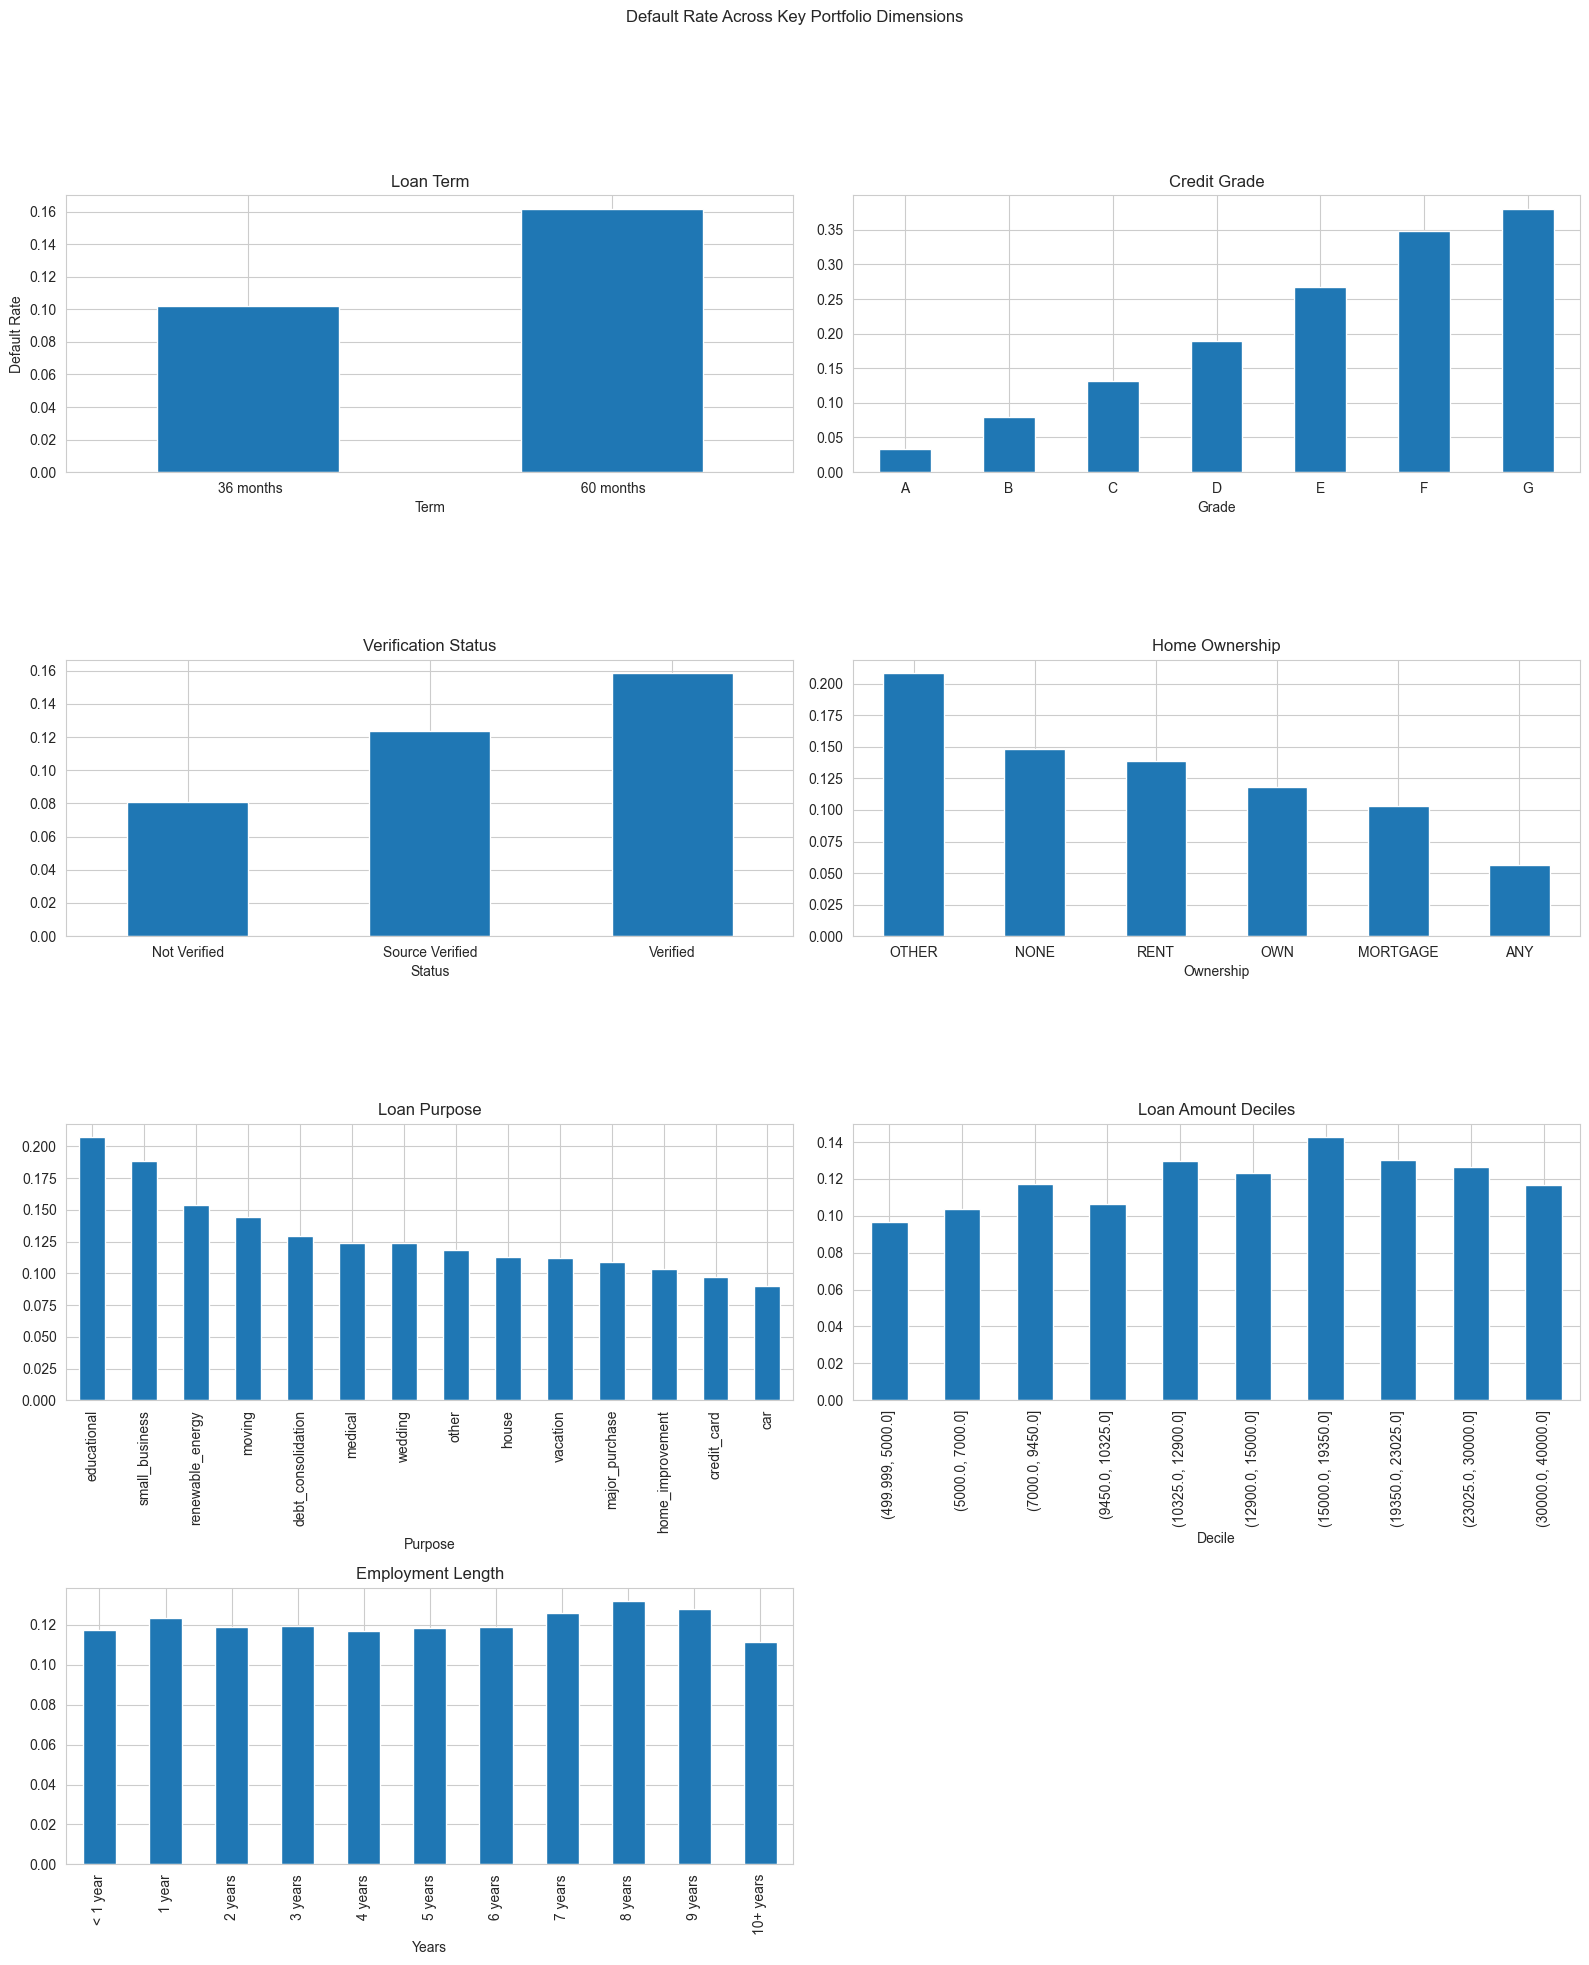

In [14]:
# Default Rate Distribution across variables under different categories in a single plot
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle("Default Rate Across Key Portfolio Dimensions", fontsize=12)

# plot 1: loan term
pd_by_term.plot(kind="bar", ax=axes[0, 0])
axes[0, 0].set_title("Loan Term")
axes[0, 0].set_xlabel("Term")
axes[0, 0].set_ylabel("Default Rate")
axes[0, 0].tick_params(axis="x", rotation=0)

# plot 2: credit grade
pd_by_grade.plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title("Credit Grade")
axes[0, 1].set_xlabel("Grade")
axes[0, 1].tick_params(axis="x", rotation=0)

# plot 3: verification status
pd_by_verification.plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title("Verification Status")
axes[1, 0].set_xlabel("Status")
axes[1, 0].tick_params(axis="x", rotation=0)

# plot 4: home ownership
pd_by_home.plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title("Home Ownership")
axes[1, 1].set_xlabel("Ownership")
axes[1, 1].tick_params(axis="x", rotation=0)

# plot 5: loan purpose
pd_by_purpose.plot(kind="bar", ax=axes[2, 0])
axes[2, 0].set_title("Loan Purpose")
axes[2, 0].set_xlabel("Purpose")
axes[2, 0].tick_params(axis="x", rotation=90)

# plot 6: loan amount deciles
pd_by_loan_amt.plot(kind="bar", ax=axes[2, 1])
axes[2, 1].set_title("Loan Amount Deciles")
axes[2, 1].set_xlabel("Decile")
axes[2, 1].tick_params(axis="x", rotation=90)

# plot 7: employment length
pd_by_emp_len.plot(kind="bar", ax=axes[3, 0])
axes[3, 0].set_title("Employment Length")
axes[3, 0].set_xlabel("Years")
axes[3, 0].tick_params(axis="x", rotation=90)

# Remove the last empty subplot (axes[3, 1])
fig.delaxes(axes[3, 1])

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

The figure above illustrates default rate variation across key portfolio dimensions. Consistent risk ordering is observed across structural (term, grade), borrower (employment length, home ownership), and loan characteristics (purpose, loan size), reinforcing the suitability of these variables for downstream PD modelling.

#### **Variable Treatment Strategy (Post-EDA)**

In this section, we formalize variable-level treatment decisions based on exploratory analysis.

Not all variables are analyzed with the same depth at this stage. Instead, we distinguish between:
- Strong, high-level drivers that were explicitly validated during EDA
- Bureau / application variables that require transformation before meaningful analysis
- Variables to be excluded due to redundancy, leakage, or poor suitability for modelling

---

**1. Bureau / Application Variables Deferred for Detailed Analysis**

The following bureau and application variables were not subjected to aggressive raw EDA (e.g. fine-grained default-rate plots by raw values). This is intentional.

These variables are typically:
- Highly skewed
- Sparse or zero-inflated
- Noisy at the raw-value level
- More meaningfully analyzed after binning or grouping

Performing raw EDA on such variables can be misleading due to low counts in tail categories and unstable default rates. These variables will be investigated in detail during monotonic binning and WOE analysis. These variables are  `annual_inc, dti, open_acc, total_acc, revol_bal, revol_util, delinq_2yrs, inq_last_6mths, pub_rec, installment`. At the EDA stage, we focused instead on high-level structural drivers (e.g. term, grade, purpose) that are easier to reason about and serve as early sanity checks for target validity.

---

**2. Variables Dropped from the Modelling Dataset**

- `emp_title`: Extremely high cardinality free-text field with limited incremental predictive value and high preprocessing complexity.

- `funded_amnt`, `funded_amnt_inv`: Highly collinear with loan_amnt and reflect funding mechanics rather than borrower credit risk.

- `issue_d`: Replaced by a standardized observation date (T0).

- `loan_status`: Final loan outcome used only to construct the default flag; retaining it would introduce target leakage.

---

**3. Variable-Level Strategy for Retained Core Variables**

- `loan_amnt`: The loan amount variable shows moderate risk differentiation across the portfolio. It is discrete and widely distributed with no evidence of instability or extreme outliers. This variable will be retained and transformed using monotonic binning. No capping is required.

- `int_rate`: Interest rate exhibits strong and monotonic separation between defaulted and non-defaulted loans. It will be retained and transformed using ordered binning to preserve monotonic risk behavior.

- `term`: Loan term shows clear and intuitive risk differentiation, with longer tenors associated with higher default rates. This variable will be retained and treated as a categorical predictor.

- `grade / sub_grade`: Credit grades demonstrate near-perfect monotonic risk ordering. Sub-grade will be preferred over grade for finer granularity and retained as an ordered categorical variable.

- `purpose`: Loan purpose shows meaningful but noisy risk differentiation. Low-frequency categories will be grouped, and the variable will be transformed using grouped categorical bins.

- `home_ownership`: Home ownership exhibits economically intuitive risk ordering. Rare categories will be combined, and the variable will be treated as an ordered categorical predictor.

- `emp_length`: Employment length shows weak monotonicity and informative missingness. This variable will be retained, coarsely grouped, and missing values treated as a separate category.

- `verification_status`: Income verification status shows clear risk differentiation, with higher observed default rates for verified loans due to risk selection effects rather than direct risk mitigation. This variable will be retained and treated as a categorical predictor without further transformation beyond grouping, if required.



In [15]:
# variables to drop based on EDA decisions
vars_to_drop = ["emp_title", "funded_amnt", "funded_amnt_inv", "issue_d", "loan_status"]
final_var_list = [col for col in model_df.columns if col not in vars_to_drop]

print("Final variables used for modelling:,\n", final_var_list)

Final variables used for modelling:,
 ['id', 'term', 'loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'purpose', 'verification_status', 'annual_inc', 'emp_length', 'home_ownership', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 't0', 'default_flag']


## **Output**

In [21]:
# storing the dataset after EDA and preliminary variable strategy decisions
model_df = model_df[final_var_list].copy()
model_df.to_pickle(f"{main_dir}/data/processed/mortgage_model_data.pkl")    

# exporting the required summaries and results in a workbook
summary_dict = {
    "Portfolio_Summary": pd.DataFrame({
        "Number_of_Loans": [n_loans],
        "Overall_Default_Rate": [overall_pd]
    }),
    "PD_by_Term": pd_by_term.to_frame(),
    "PD_by_Grade": pd_by_grade.to_frame(),
    "PD_by_Purpose": pd_by_purpose.to_frame(),
    "PD_by_Verification_Status": pd_by_verification.to_frame(),
    "PD_by_Loan_Amount_Deciles": pd_by_loan_amt.to_frame(),
    "Missing_Value_Percentages": missing_pct[missing_pct > 0].to_frame(),
    "Loan_Amount_Summary_by_DF": loan_amt_stats,
    "Interest_Rate_Summary_by_DF": int_rate_stats,
    "DTI_Summary_by_DF": dti_stats,
    "Delinq_2yrs_Summary_by_DF": delinq_stats,
    "Inq_Last_6mths_Summary_by_DF": inq_stats,
    "PD_by_Home_Ownership": pd_by_home.to_frame(),
    "PD_by_Employment_Length": pd_by_emp_len.to_frame(),
    "PD_by_Missing_Emp_Length": pd_by_emp_len_missing.to_frame(),
    "PD_by_Missing_Revol_Util": pd_by_revol_util_missing.to_frame()
}

export_dict_to_excel(summary_dict, f"{main_dir}/summaries_and_charts/mortgage_eda_summary.xlsx")

# storing the plot 
fig.savefig(f"{main_dir}/summaries_and_charts/mortgage_default_rate_summary.png", dpi=300)

Excel file saved at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//summaries_and_charts/mortgage_eda_summary.xlsx
